### Import

In [1]:
import numpy as np
import math
import random
import pickle
import matplotlib.pyplot as plt 

import torch
import torch.nn as nn
import torch.optim as optim
from torchtext import data
from tqdm import tnrange, tqdm_notebook
from data_loader import DataLoader

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix 
from sklearn.feature_extraction.text import CountVectorizer

%load_ext autoreload
%autoreload 2

### Load Data

In [2]:
data_loader = DataLoader()
train, valid = data_loader.large_train_valid()

building data...
saving data at dataset/train_data.pt, dataset/test_data.pt
splitting data...
building vocabulary...


In [3]:
print('%d training examples' %len(train))
print('%d validation examples' %len(valid))

20000 training examples
5000 validation examples


In [4]:
def make_corpus(torchtext_data):
    corpus = [' '.join(data.text).replace("<br />","").replace("< br />","") for data in torchtext_data]
    return corpus

def true_label(data):    
    label = [1 if data[i].label[0] == 'pos' else 0 for i in range(len(data))]
    return label

def corpus_vectorize(corpus, vectorizer):
    matrix = vectorizer.transform(corpus)
    matrix = matrix.toarray()
    return matrix

y_train = true_label(train)
train_corpus = make_corpus(train)

y_valid = true_label(valid)
valid_corpus = make_corpus(valid)

uni_vectorizer = CountVectorizer(max_features= 30000)
uni_vectorizer.fit(train_corpus)

bi_vectorizer = CountVectorizer(ngram_range= (2,2), max_features= 30000)
bi_vectorizer.fit(train_corpus)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=30000, min_df=1,
        ngram_range=(2, 2), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [5]:
uni_train = corpus_vectorize(train_corpus, uni_vectorizer)
bi_train = corpus_vectorize(train_corpus, bi_vectorizer)

In [6]:
uni_valid = corpus_vectorize(valid_corpus, uni_vectorizer)
bi_valid = corpus_vectorize(valid_corpus, bi_vectorizer)

## Naive Bayes - Unigram 

In [7]:
uniNB = MultinomialNB()
uniNB.fit(uni_train, y_train)
uni_pred = uniNB.predict(uni_valid)
uniTrainScore = uniNB.score(uni_train, y_train)
uniValidScore = uniNB.score(uni_valid, y_valid)

print("unigram - train dataset accuracy", uniTrainScore)
print("unigram - valid dataset accuracy", uniValidScore)

unigram - train dataset accuracy 0.88945
unigram - valid dataset accuracy 0.8522


## Naive Bayes - Bigrams

In [8]:
biNB = MultinomialNB()
biNB.fit(bi_train, y_train)
bi_pred = biNB.predict(bi_valid)
biTrainScore = biNB.score(bi_train, y_train)
biValidScore = biNB.score(bi_valid, y_valid)

print("bigram - train dataset accuracy", biTrainScore)
print("bigram - valid dataset accuracy", biValidScore)

bigram - train dataset accuracy 0.9115
bigram - valid dataset accuracy 0.8752


## Adversary - Swap Word (blackbox)

In [9]:
# Because we perform one swap per word, but do not alter the first or last letters.
# This noise is only applied to words of length > 3.
# noise -> niose

def swap(word):
    rand = random.randint(1,len(word)-3)
    return word[:rand] +  word[rand:rand+2][::-1] + word[rand+2:]

def adversary_swap(adversary_data, propotion):
    """
    Randomly swap characters in words in text, parameter 'propotion' decides how many words are swapped
    e.g. noise -> niose 
    """
    for i in range(len(adversary_data)):
        rand_sample = random.sample(np.arange(0, len(adversary_data[i].text)).tolist(), int(len(adversary_data[i].text)*propotion))
        for pick in rand_sample:
            if len(adversary_data[i].text[pick]) > 3:
                # print(adversary_data[i].text[pick], "->", swap(adversary_data[i].text[pick]))
                adversary_data[i].text[pick] = swap(adversary_data[i].text[pick])
        # print(" ")
        # print(i, "SWAP END")
        # print(" ")
        
    return adversary_data

In [10]:
train_cv, valid_cv = data_loader.small_train_valid()
y_valid_cv = true_label(valid_cv)

splitting data...
building vocabulary...


In [11]:
def swap_accuracy(proportion):
    """
    to decide what propotion of words to be swapped    
    """
    with open('./dataset/test.pickle', 'rb') as handle:
        test = pickle.load(handle)

    adv = adversary_swap(test, proportion)
    adv_corpus = make_corpus(adv)
    uni_adv = corpus_vectorize(adv_corpus, uni_vectorizer)
    bi_adv = corpus_vectorize(adv_corpus, bi_vectorizer)
    
    uni_score = uniNB.score(uni_adv, y_valid_cv)
    bi_score = biNB.score(bi_adv, y_valid_cv)

    return uni_score, bi_score 

In [58]:
swap_rate = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

uni_list = []
bi_list = []

for i in swap_rate:
    u, b = swap_accuracy(i)
    uni_list.append(u)
    bi_list.append(b)

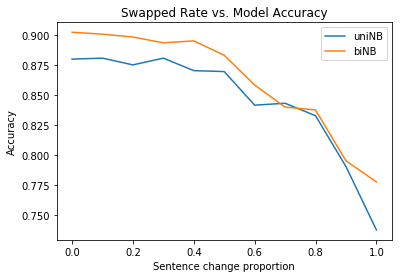

In [59]:
plt.plot(swap_rate, uni_list, label = "uniNB")
plt.plot(swap_rate, bi_list, label = "biNB")

plt.title("Swapped Rate vs. Model Accuracy")
plt.xlabel("Sentence change proportion")
plt.ylabel("Accuracy")

plt.legend()
plt.show()

In [52]:
with open('adv.pickle', 'rb') as handle:
    adv = pickle.load(handle)
    
adversary = adversary_swap(adv, 0.5)
adv_corpus = make_corpus(adversary)
uni_adv = corpus_vectorize(adv_corpus, uni_vectorizer)
bi_adv = corpus_vectorize(adv_corpus, bi_vectorizer)

In [53]:
uni_adv_pred = uniNB.predict(uni_adv)
bi_adv_pred = biNB.predict(bi_adv)

### Result

In [54]:
print("unigram - valid dataset accuracy", uniNB.score(uni_valid, y_valid))
print("unigram - adversary dataset accuracy", uniNB.score(uni_adv, y_valid))
print("accuracy decrease after attack {:.3f}".format(uniNB.score(uni_adv, y_valid)- uniNB.score(uni_valid, y_valid)) )

print("")
print("bigram - valid dataset accuracy", biNB.score(bi_valid, y_valid))
print("bigram - adversary dataset accuracy", biNB.score(bi_adv, y_valid))
print("accuracy decrease after attack {:.3f}".format(biNB.score(bi_adv, y_valid) - biNB.score(bi_valid, y_valid)))

unigram - valid dataset accuracy 0.8522
unigram - adversary dataset accuracy 0.8302
accuracy decrease after attack -0.022

bigram - valid dataset accuracy 0.8752
bigram - adversary dataset accuracy 0.8406
accuracy decrease after attack -0.035


In [55]:
def success_rate(valid_pred, adv_pred):
    correct_id = []
    ct = 0
    for i in range(len(y_valid)):
        if valid_pred[i] == y_valid[i] and valid_pred[i] != adv_pred[i]:
            ct += 1
            
    fliprate = ct/len(y_valid)
    
    return fliprate


In [56]:
success_rate(uni_pred, uni_adv_pred)

0.0418

In [57]:
success_rate(bi_pred, bi_adv_pred)

0.058

## Adversary - greedy (whitebox)

In [23]:
with open('greedy-examples.pkl', 'rb') as handle:
    greedy = pickle.load(handle)

greedy_index = []
greedy_sentiment = []
greedy_text = []
    
global greedy_index
global greedy_sentiment
global greedy_text

for (idx, sen, text) in greedy:
    greedy_text.append(text)
    greedy_index.append(idx)
    if sen[0] == 'pos':
        greedy_sentiment.append(1)
    else:
        greedy_sentiment.append(0)

In [39]:
def flip_rate(pred_model, pred_label, vectorizer):
 
    correct_id = []

    for i in range(len(greedy_text)):
        if pred_label[greedy_index[i]] == y_valid[greedy_index[i]]:
            correct_id.append(i)
    print(len(correct_id))
    
    greedy_corpus = corpus_vectorize(greedy_text, vectorizer)
    greedy_pred = pred_model.predict(greedy_corpus)
    
    ct = 0
    for i in correct_id:
        if greedy_pred[i] != greedy_sentiment[i]:
            ct += 1
    
    fliprate = ct/len(correct_id)
    
    return fliprate


In [40]:
flip_rate(uniNB, uni_pred, uni_vectorizer)

442


0.083710407239819

In [41]:
flip_rate(biNB, bi_pred, bi_vectorizer)

454


0.046255506607929514

### Save

In [ ]:

# save model 
filename = 'uniNB_model.sav'
pickle.dump(uniNB, open(filename, 'wb'))

filename = 'biNB_model.sav'
pickle.dump(biNB, open(filename, 'wb'))

In [ ]:
# load model
uniNB = pickle.load(open('./uniNB_model.sav', 'rb'))
biNB = pickle.load(open('./biNB_model.sav', 'rb'))

In [ ]:
# save test data
for data in valid:
    print(data)
    break

In [ ]:
raw_X = [data for data in valid]
with open('test.pickle', 'wb') as handle:
    pickle.dump(raw_X, handle)

In [ ]:
raw_X = [data for data in valid]
with open('adv.pickle', 'wb') as handle:
    pickle.dump(raw_X, handle)